In [1]:

import sys
import os

sys.path.append('../')
import numpy as np 
import matplotlib.pyplot as plt 
import src_experiment as scf
import geobin as gb 
import pathlib as pl
import torch
from sklearn.datasets import make_moons


training_seed = 42
testing_seed = 41
inference_seed = 40



# Read config file and/or parse cmb-line arguments
# args = scf.get_args()



# # Check if the experiment path exists, if not, create 
# experiment_path = scf.get_path_to_experiment_storage(args.experiment_name)
# state_dict_path = experiment_path/"state_dicts"
# if not state_dict_path.exists():
#     scf.createfolders(state_dict_path)

# Make the data
train_data = scf.make_moon_dataloader(n_samples=15000, noise=0.15, random_state=training_seed, batch_size=250)
test_data = scf.make_moon_dataloader(n_samples=2000, noise=0.15, random_state=testing_seed, batch_size=250)


# # Set up the model based on the parsed arguments or the config file
model = scf.NeuralNet(input_size=2, hidden_sizes=[2,6,2], num_classes=1)

experiment_path = scf.get_path_to_experiment_storage("testing")
state_dict_path = experiment_path/"state_dicts"
if not state_dict_path.exists():
    scf.createfolders(state_dict_path)
    
    
train_metrics, state_dicts = scf.train_model(model, train_data, test_data, 100, SAVE_STATES=False, save_everyth_epoch=10, RETURN_STATES=True)

100%|██████████| 100/100 [00:10<00:00,  9.71it/s]


In [2]:
state_dicts

{0: OrderedDict([('l1.weight',
               tensor([[ 0.1727,  0.4623],
                       [ 0.3422, -0.5545]])),
              ('l1.bias', tensor([0.1644, 0.0824])),
              ('l2.weight',
               tensor([[-0.5675,  0.0175],
                       [ 0.5124,  0.1194],
                       [ 0.0096, -0.4952],
                       [ 0.0894, -0.6515],
                       [-0.5096,  0.4220],
                       [-0.4964, -0.1664]])),
              ('l2.bias',
               tensor([ 0.0362, -0.5296,  0.5249,  0.4077,  0.3725, -0.0559])),
              ('l3.weight',
               tensor([[-0.2477,  0.0570, -0.1925, -0.1673,  0.1757,  0.0890],
                       [ 0.0356, -0.2292,  0.3333,  0.1722,  0.0811, -0.0152]])),
              ('l3.bias', tensor([ 0.0224, -0.2916])),
              ('l4.weight', tensor([[ 0.2787, -0.2124]])),
              ('l4.bias', tensor([-0.5114]))]),
 10: OrderedDict([('l1.weight',
               tensor([[ 0.0613,  0.5248],
      

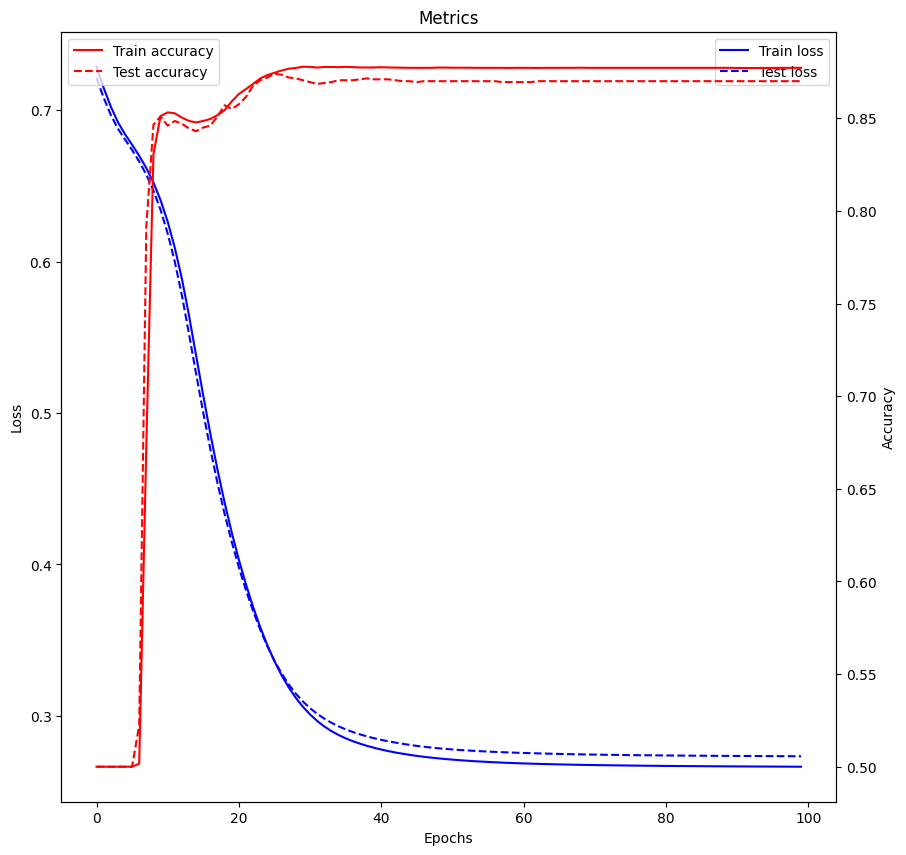

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(train_metrics["train_loss"], color="blue", label="Train loss")
ax.plot(train_metrics["test_loss"], color="blue", ls="dashed", label="Test loss")

ax2 = ax.twinx()
ax2.plot(train_metrics["train_accuracy"], color="red", label="Train accuracy")
ax2.plot(train_metrics["test_accuracy"], color="red", ls="dashed", label="Test accuracy")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")

ax.set_title("Metrics")
ax.legend()
ax2.legend()

In [4]:
inference_data = scf.make_moon_dataloader(n_samples=10000, noise=0.15, random_state=inference_seed, batch_size=250)

In [5]:
import os
lwmi_per_epoch = {}
for epoch, state_dict in state_dicts.items():
    # print(epoch,state_dict)
    # Find epoch
    # epoch = eval(state_dict[13:-4])
    # epoch = eval(epoch)
    # Load state dict
    # state_dict = torch.load(state_dict_path / state_dict)
    
    # Build tree
    tree = gb.RegionTree(state_dict)
    tree.build_tree(verbose=True)
    
    # Pass inference data through tree
    tree.pass_dataloader_through_tree(inference_data)
    # Find the number counts
    tree.collect_number_counts()
    ncounts = tree.get_number_counts()
    
    # Calculate layer-wise mi from number counts
    lwmi = gb.layer_wise_MI_from_number_counts(ncounts)
    
    # Store
    lwmi_per_epoch[epoch] = lwmi
    
    

Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 40.63it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 44.23it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 48.41it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 11.30it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 48.18it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 48.93it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 44.56it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 55.33it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 52.21it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 49.06it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Building tree...


Layer 4 / 4: 100%|██████████| 2/2 [00:00<00:00, 46.02it/s]
/home/johan/Documents/phd/WP1/geometric_binning_estimator/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# tree.reset_counters()
# tree.collect_number_counts()
# tree.get_number_counts()

,layer_idx,region_idx,total


In [6]:
lwmi_per_epoch

{0: {1: 0.2700481953838829,
  2: 0.33830379277750705,
  3: 0.36907763357661166,
  4: 0.36907763357661166},
 10: {1: 0.29841831097408966,
  2: 0.3886988929131602,
  3: 0.39925794898739403,
  4: 0.4034315438939808},
 20: {1: 0.3460817282222758,
  2: 0.40387186269894404,
  3: 0.415819203844212,
  4: 0.4229979795775447},
 30: {1: 0.31741207375560315,
  2: 0.3610287233396545,
  3: 0.37760895275231693,
  4: 0.41750015140172725},
 40: {1: 0.26747065532749487,
  2: 0.30287830904016905,
  3: 0.3281833277259812,
  4: 0.4045211355991136},
 50: {1: 0.21909538459146416,
  2: 0.24849411289517512,
  3: 0.27607896252808056,
  4: 0.39004643798643823},
 60: {1: 0.18329436145649997,
  2: 0.20974316444648114,
  3: 0.23201456075093915,
  4: 0.377892768398655},
 70: {1: 0.15179407431890632,
  2: 0.18062169580224038,
  3: 0.2007827628349827,
  4: 0.36952785887287865},
 80: {1: 0.12791351943771537,
  2: 0.1625235449355797,
  3: 0.17844658127451465,
  4: 0.36306326451769616},
 90: {1: 0.11059059453191147,
  2:

In [7]:
from collections import defaultdict

layer_to_mi = defaultdict(dict)

# Build inverted dictionary
for epoch, layer_dict in lwmi_per_epoch.items():
    for layer, mi in layer_dict.items():
        layer_to_mi[layer][epoch] = mi

# Sort by epoch number
layer_to_mi = {
    layer: dict(sorted(epoch_dict.items(), key=lambda x: x[0]))
    for layer, epoch_dict in layer_to_mi.items()
}

In [8]:
layer_to_mi

{1: {0: 0.2700481953838829,
  10: 0.29841831097408966,
  20: 0.3460817282222758,
  30: 0.31741207375560315,
  40: 0.26747065532749487,
  50: 0.21909538459146416,
  60: 0.18329436145649997,
  70: 0.15179407431890632,
  80: 0.12791351943771537,
  90: 0.11059059453191147,
  99: 0.09681901191224135},
 2: {0: 0.33830379277750705,
  10: 0.3886988929131602,
  20: 0.40387186269894404,
  30: 0.3610287233396545,
  40: 0.30287830904016905,
  50: 0.24849411289517512,
  60: 0.20974316444648114,
  70: 0.18062169580224038,
  80: 0.1625235449355797,
  90: 0.1540693228992969,
  99: 0.1498970977189442},
 3: {0: 0.36907763357661166,
  10: 0.39925794898739403,
  20: 0.415819203844212,
  30: 0.37760895275231693,
  40: 0.3281833277259812,
  50: 0.27607896252808056,
  60: 0.23201456075093915,
  70: 0.2007827628349827,
  80: 0.17844658127451465,
  90: 0.16475674743257404,
  99: 0.15912415140258074},
 4: {0: 0.36907763357661166,
  10: 0.4034315438939808,
  20: 0.4229979795775447,
  30: 0.41750015140172725,
  4

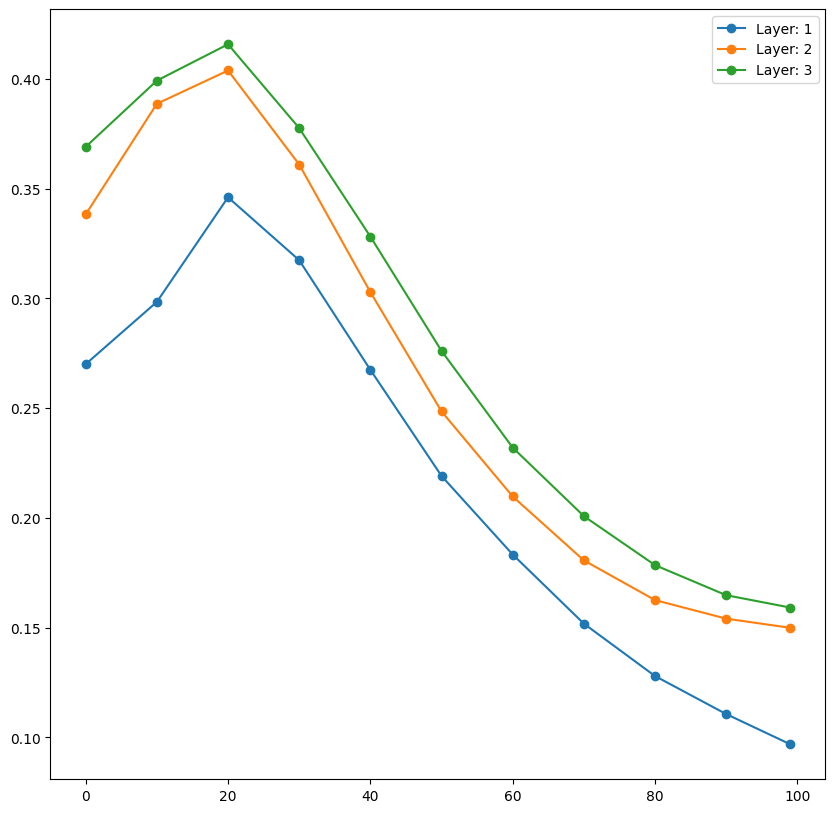

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

# iterate over all layers except the last one
for layer, val in list(layer_to_mi.items())[:-1]:
    ax.plot(val.keys(), val.values(), "o-", label=f"Layer: {layer}")

ax.legend()
plt.show()